# AR view simulation. Transformation between MRI to endoscope video

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu
import nibabel as nib



In [17]:
def centre_transform(T, origin):
    T1 = np.eye(4)
    T1[0:3,3]= np.array(origin) # translation of origin to centre of image
    T2 = np.linalg.inv(T1) # inverse translation back to origina location

    centred_transform = np.dot(T1, np.dot( T , T2 ))
    centred_transform[0:3, 3] += T[0:3, 3]
    return centred_transform

def get_transform(T, origin):

    THom = np.eye(4)

    THom[0,3] = T[0]
    THom[1,3] = T[1]
    THom[2,3] = T[2]

    # defining rotation in x
    theta_x = T[3] * np.pi /180
    rotX = np.eye(4)
    if theta_x != 0:
        rotX[1, 1] = np.cos(theta_x)
        rotX[2, 2] = np.cos(theta_x)
        rotX[2, 1] = np.sin(theta_x)
        rotX[1, 2] = -np.sin(theta_x)

    # defining rotation in y
    theta_y = T[4] * np.pi /180
    rotY = np.eye(4)
    if theta_y != 0:
        rotY[0, 0] = np.cos(theta_y)
        rotY[2, 2] = np.cos(theta_y)
        rotY[0, 2] = np.sin(theta_y)
        rotY[2, 0] = -np.sin(theta_y)

    # defining rotation in z
    theta_z = T[5] * np.pi /180
    rotZ = np.eye(4)
    if theta_z != 0:
        rotZ[0, 0] = np.cos(theta_z  )
        rotZ[1, 1] = np.cos(theta_z )
        rotZ[1, 0] = np.sin(theta_z )
        rotZ[0, 1] = -np.sin(theta_z )

    # combining rotation matrices with translation to rotate around centre
    rotations = centre_transform(rotX @ rotY @ rotZ, origin)

    # scaling
    S = np.eye(4)
    if len(T)==7:
        # making 3 values at diagonals scale factor
        S = S * T[6]
        S[-1,-1] = 1
        S = centre_transform(S, origin)

    # multiplying all these matrices to get final transform
    THom = THom @ S @ rotations
    return THom

In this setup, the goal is to display data from the endoscope overlaid on the CT scan. This means we have to convert endoscope coordinates to CT coordinates 

In [120]:
img = nib.load('./mri_data/mdeft.1.nii.gz').get_fdata()
# first taking the transpose of the matrix (switching x and y dimensions)
# then flipping along the second dimension (moving the first pixel from the top to the bottom of the image
img = np.flip(img, axis=1)
 
# pituitary gland at approx 95, 110, 85
pituitary_position = [95, 250-110, 85]

(224, 256, 176)


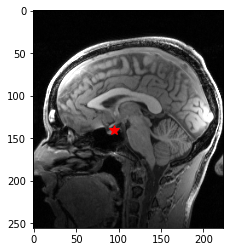

In [121]:
print(img.shape)

img_slice = img[:,:,pituitary_position[2]].T
plt.figure()
plt.imshow(img_slice, cmap='gray', vmin=0, vmax=650)
plt.plot(pituitary_position[0], pituitary_position[1] , marker='*', color='r', ms=10)
plt.show()

## Assumptions

In [122]:
distance_from_cam = 1000 # distance from camera to axis where cancer is
end_length = 100 # length from endoscope end point to marker of endoscope

# CT/MRI coords to world coordinates

We start by converting our MRI coordinates to camera coordinates. This is done by surface calibration


We typically would take the marker and move it over the surface of the patient's head. We then use an ICP algorithm to match the two surfaces- of the points on the face and those on the MRI.

We assume however for the purpose of this simulation that we know the transformation from the MRI to camera coordinates. We assume the MRI scan coordinates are translated by a certain amount from the patient coordinates.

In [20]:
point_in_cam

array([   0,    0, 1000,    1])

In [40]:
# average head dimensions from: https://en.wikipedia.org/wiki/Human_head
#x = 10 # head length (about 20)
#y = 13 # menton to top of head (about 25)
#z = -8 # head bredth (about 15)
x = pituitary_position[0]
y = pituitary_position[1]
z = pituitary_position[2]
translations = [x,y,z, 0, 0, 0]
origin = [0,0,0]
cam_to_MRI = get_transform(translations, origin)
print(cam_to_MRI)


[[  1.   0.   0.  95.]
 [  0.   1.   0. 140.]
 [  0.   0.   1.  85.]
 [  0.   0.   0.   1.]]


### Getting camera to MRI transform <sup>MRI</sup>T<sub>Cam</sub>

In [41]:
R_cam_MRI = cam_to_MRI[:3,:3]
t_cam_MRI = np.array([cam_to_MRI[:3,3]]).T
print(R_cam_MRI)
print(t_cam_MRI)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 95.]
 [140.]
 [ 85.]]


In [42]:
point_in_cam = np.array([0,0,distance_from_cam,1])
print(point_in_cam)

#print(cam_to_MRI@point_in_cam.T)
point_in_MRI = ((R_cam_MRI@point_in_cam[0:3].T) + t_cam_MRI.T)
print('in mri')

print(point_in_MRI)

[   0    0 1000    1]
in mri
[[  95.  140. 1085.]]


# Endoscope to camera coords

In [14]:
end_ref = np.zeros((4, 3)) 

# defining reference coordibates in ref coords
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45

end_ref[1][1] = 28.59 
end_ref[1][2] = 41.02 
end_ref[2][2] = 88 
end_ref[3][1] = -44.32 
end_ref[3][2] = 40.45

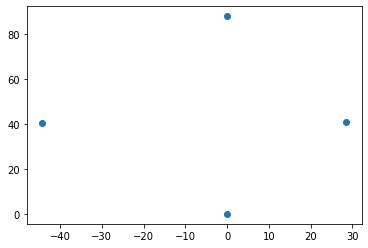

In [15]:
plt.scatter(end_ref[:,1], end_ref[:,2])
plt.show()

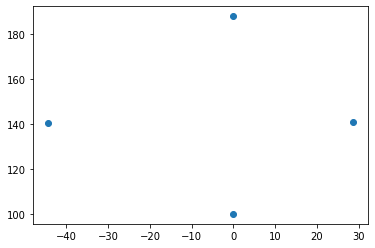

In [16]:
# adding length of endoscope
end_ref_transformed = np.copy(end_ref)

# adding pointer length to each coords in z direction
end_ref_transformed[:,2] += end_length

plt.scatter(end_ref_transformed[:,1], end_ref_transformed[:,2])
plt.show()

# adding tip to endoscope
end_tip = np.array([[0,0,0]])
end_ref_with_tip = np.concatenate((end_ref_transformed, end_tip), axis=0)

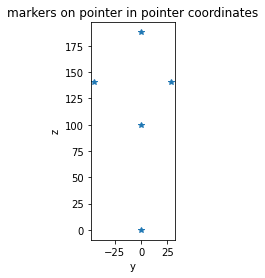

In [17]:

plt.figure()
plt.plot(end_ref_with_tip[:,1],end_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

[[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]]
[[  0.     0.   100.  ]
 [  0.    28.59 141.02]
 [  0.     0.   188.  ]
 [  0.   -44.32 140.45]]
[[   0.          -70.71067812   70.71067812    0.        ]
 [   0.          -79.50001541  119.93238116    0.        ]
 [   0.         -132.93607486  132.93607486    0.        ]
 [   0.         -130.65211996   67.97417488    0.        ]]


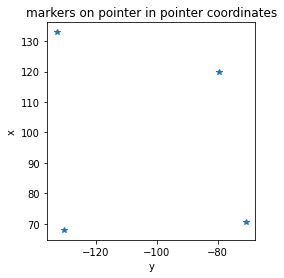

In [22]:
# setting transform and origin of rotation
T = [0,0,0,45,0,0] #([Tx, Ty, Tz, Rx, Ry, Rz])
origin = [0, 0 , 0]

# getting homogenous transformation
THom = get_transform(T,origin)
print(THom[:3, :])
print(end_ref_transformed)

# transforming with this transform
transformed_end = (THom[:,:3] @ end_ref_transformed.T).T
print(transformed_end)

# plotting result

plt.figure()
plt.plot(transformed_end[:,1],transformed_end[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Transforming to camera coordinates

In [23]:
# turning z axis to D
transformed_end[0:4,3] = distance_from_cam
print(transformed_end)


[[   0.          -70.71067812   70.71067812 1000.        ]
 [   0.          -79.50001541  119.93238116 1000.        ]
 [   0.         -132.93607486  132.93607486 1000.        ]
 [   0.         -130.65211996   67.97417488 1000.        ]]


### Now getting camera reference point in camera coordinates  <sup>endRef</sup> T <sub>cam</sub>

In [43]:
# getting the transformation from endoscope's marker coords to camera coordinates

R_endRef_cam, t_endRef_cam, FRE_endRef_cam = pro.orthogonal_procrustes(end_ref_transformed , transformed_end[:,1:])
print(R_endRef_cam)
print(t_endRef_cam)
print(FRE_endRef_cam)

[[ 0.          0.          1.        ]
 [ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]]
[[-1.00000000e+03]
 [ 4.44089210e-15]
 [ 2.84217094e-14]]
2.5003445110377325e-14


# Endoscope marker to endoscope camera

For the purpose of simulation, this will simply be the length of the endoscope

### endoscope reference to endoscope point  <sup>endP</sup> T <sub>endRef</sub>

In [18]:
R_endP_endRef, t_endP_endRef, FRE_endP_endRef = pro.orthogonal_procrustes(end_ref , end_ref_transformed)
print(R_endP_endRef)
print(t_endP_endRef) # should be 100 in z direction
print(FRE_endP_endRef)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.24900090e-16]
 [ 0.00000000e+00 -1.17961196e-16  1.00000000e+00]]
[[ 0.00000000e+00]
 [-1.77635684e-14]
 [-1.00000000e+02]]
9.531848210733148e-15


# Projecting 3D points to 2D


In [25]:
# we start with a point in world space- eg. the cancer
cancer_coords = np.array([[0,0,0]])
cancer_coords 

array([[0, 0, 0]])